In [36]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = 'w'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'gray'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['axes.axisbelow'] = True

In [37]:
df_ativo = yf.download('BOVA11.SA',start='2010-01-01').dropna()
df_ativo = df_ativo.dropna()
df_ativo = df_ativo.drop(df_ativo.index[-1])

[*********************100%%**********************]  1 of 1 completed


In [38]:
from ta.momentum import rsi
rsi_close = rsi(df_ativo['Adj Close'])


In [39]:
from ta.trend import EMAIndicator
ema_volume = EMAIndicator(df_ativo['Volume'],window=9)
ema_volume = ema_volume.ema_indicator()
Vol_relativo = df_ativo['Volume']/ema_volume


In [40]:
df_ativo['RSI'] = rsi_close
df_ativo['Vol_relativo'] = Vol_relativo
df_ativo = df_ativo.dropna()
df_ativo

,Open,High,Low,Close,Adj Close,Volume,RSI,Vol_relativo
Date,,,,,,,,
2010-01-21,68.000000,68.000000,65.370003,65.900002,65.900002,995600,20.781057,2.606216
2010-01-22,65.599998,65.959999,64.910004,65.589996,65.589996,653300,19.635611,1.497474
2010-01-26,65.050003,65.360001,64.120003,64.980003,64.980003,456800,17.582011,1.037299
2010-01-27,64.989998,65.000000,63.900002,64.900002,64.900002,443900,17.326075,1.006395
2010-01-28,65.059998,66.489998,63.980000,65.199997,65.199997,243700,21.916187,0.606817
...,...,...,...,...,...,...,...,...
2024-06-11,117.500000,118.220001,117.379997,118.000000,118.000000,5365316,36.157540,1.108799
2024-06-12,118.870003,118.870003,116.010002,116.459999,116.459999,13576008,31.066434,2.061254
2024-06-13,116.500000,116.790001,115.730003,116.180000,116.180000,6118398,30.232919,0.942349


In [41]:
rsi_close = df_ativo['RSI']
vol_rel = df_ativo['Vol_relativo']
max_RSI = df_ativo['RSI'].max()
min_RSI = df_ativo['RSI'].min()
max_vol_rel = df_ativo['Vol_relativo'].max()
min_vol_rel = df_ativo['Vol_relativo'].min()

rsi_fuzz = ctrl.Antecedent(np.arange(min_RSI, max_RSI, 0.1), 'RSI')
vol_rel_fuzz = ctrl.Antecedent(np.arange(min_vol_rel, max_vol_rel,0.01), 'Vol_relativo')
dec = ctrl.Consequent(np.arange(0,10, 0.1), 'decisao')

c:\Users\caiof\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



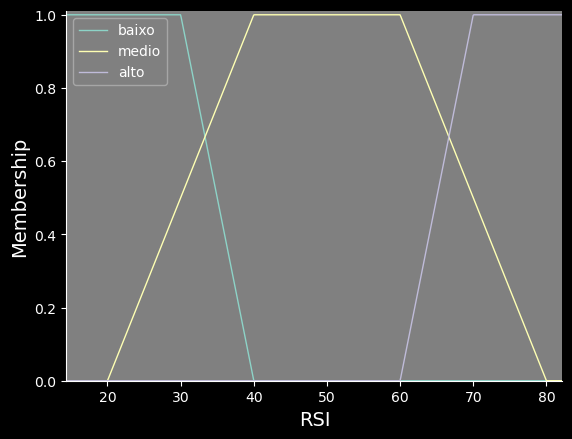

In [42]:
rsi_fuzz['baixo'] = fuzz.trapmf(rsi_fuzz.universe, [0,0,30,40]) 
rsi_fuzz['medio'] = fuzz.trapmf(rsi_fuzz.universe, [20,40,60,80]) 
rsi_fuzz['alto'] = fuzz.trapmf(rsi_fuzz.universe, [60,70,100,100])
rsi_fuzz.view()

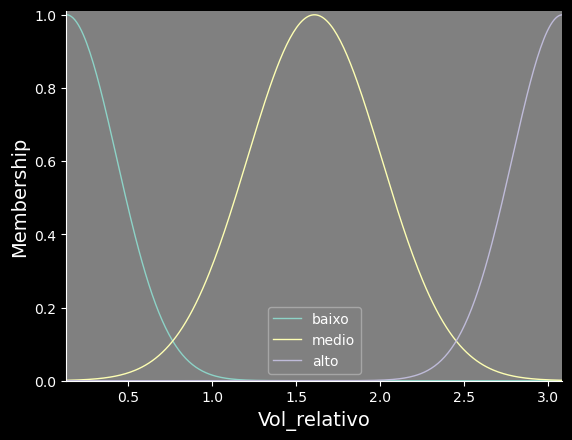

In [43]:
vol_rel_fuzz['baixo'] = fuzz.gaussmf(vol_rel_fuzz.universe, min_vol_rel, 0.3)
vol_rel_fuzz['medio'] = fuzz.gaussmf(vol_rel_fuzz.universe, (max_vol_rel+min_vol_rel)/2, 0.4)
vol_rel_fuzz['alto'] = fuzz.gaussmf(vol_rel_fuzz.universe, max_vol_rel, 0.3)
vol_rel_fuzz.view()


c:\Users\caiof\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



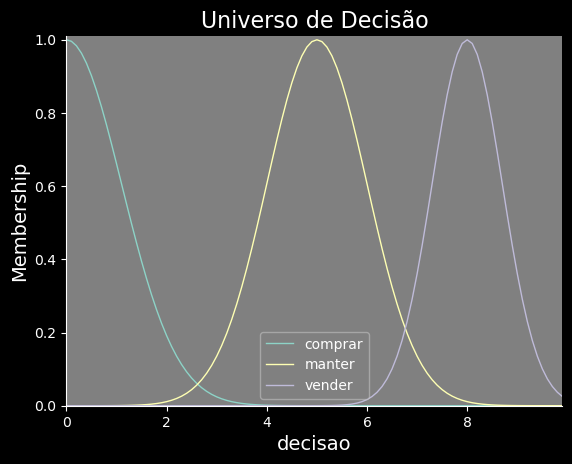

In [50]:
dec['comprar'] = fuzz.gaussmf(dec.universe,0,1.1)
dec['manter'] = fuzz.gaussmf(dec.universe,5,1)
dec['vender'] = fuzz.gaussmf(dec.universe,8,0.7)
dec.view()
plt.title('Universo de Decisão')
plt.savefig('universo decisão.png')


In [45]:
regra1 = ctrl.Rule(rsi_fuzz['baixo'] & vol_rel_fuzz['baixo'], dec['comprar'])
regra2 = ctrl.Rule(rsi_fuzz['baixo'] & vol_rel_fuzz['medio'], dec['comprar'])
regra3 = ctrl.Rule(rsi_fuzz['baixo'] & vol_rel_fuzz['alto'] , dec['comprar'])
regra4 = ctrl.Rule(rsi_fuzz['medio'] & vol_rel_fuzz['alto'], dec['manter'])
regra5 = ctrl.Rule(rsi_fuzz['medio'] & vol_rel_fuzz['medio'], dec['manter'])
regra6 = ctrl.Rule(rsi_fuzz['alto']  & vol_rel_fuzz['baixo'], dec['manter'])
regra7 = ctrl.Rule(rsi_fuzz['alto']  & vol_rel_fuzz['medio'], dec['vender'])
regra8= ctrl.Rule(rsi_fuzz['alto']  & vol_rel_fuzz['alto'], dec['vender'])


decisao_ctrl = ctrl.ControlSystem([regra1,regra2,regra3,regra5,regra6,regra7,regra4,regra8])
decisao = ctrl.ControlSystemSimulation(decisao_ctrl)

def fn_resfzy(entrada):
    decisao.input['RSI'] = entrada[0]
    decisao.input['Vol_relativo'] = entrada[1]
    decisao.compute()
    return decisao.output['decisao']


0       comprar
1       comprar
2       comprar
3       comprar
4       comprar
         ...   
3542     manter
3543     manter
3544     manter
3545     manter
3546    comprar
Length: 3547, dtype: object


c:\Users\caiof\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



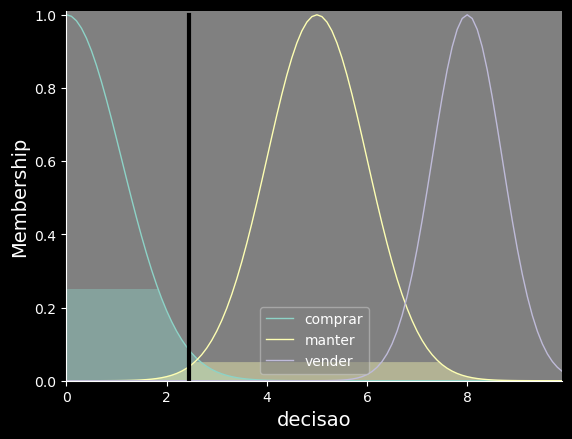

In [46]:
mval = np.zeros((len(df_ativo),3))
for i in range(len(df_ativo)):
    resl = fn_resfzy([df_ativo['RSI'].values[i],
                      df_ativo['Vol_relativo'].values[i]])
    j=0
    for t in dec.terms:
        s = np.interp(resl,dec.universe,dec[t].mf)
        mval[i,j] = s
        j +=1
mval = pd.DataFrame(mval,columns=['comprar','manter','vender'])
dec_fuzzy = mval.idxmax(axis=1)
print(dec_fuzzy)

dec.view(sim=decisao)





In [47]:
fig = make_subplots(
    rows=3,
    cols=1,
    row_heights=[5, 3, 3],
)
fig.add_trace(go.Line(x=df_ativo.index, y=df_ativo['Adj Close'],name='IBOV',line=dict(color='white')
                                            ),row=1, col=1)
fig.add_trace(go.Bar(name='Volume', x=df_ativo.index, y=df_ativo['Volume'], marker_color='#54d4d6'), row=2,col=1)


fig.add_trace(go.Line(name='RSI', x=df_ativo.index, y=df_ativo['RSI'],line=dict(color='#941818')), row=3,col=1)
fig.add_shape(
    type="line",
    x0=df_ativo.index[0],y0=30,
    x1=df_ativo.index[-1],y1=30,
    line=dict(color="#00FF00", width=0.5, dash='dash'),
    row=3,col=1,
)
fig.add_shape(
    type="line",
    x0=df_ativo.index[0],y0=70,
    x1=df_ativo.index[-1],y1=70,
    line=dict(color="#00FF00", width=0.5, dash='dash'),
    row=3,col=1,
)


fig.update_xaxes(rangebreaks=[dict(bounds=['sat', 'mon'])])

annotations = []
for i in range(len(dec_fuzzy)):
    if dec_fuzzy[i] == 'comprar':
        annotations.append(dict(
            x=df_ativo.index[i],
            y=df_ativo['Adj Close'].values[i],
            text='^',
            showarrow=True,arrowhead=4,
            ax=0,ay=-10,
            font=dict(color='green',size=18)
        ))
    elif dec_fuzzy[i] == 'vender':
        annotations.append(dict(
            x=df_ativo.index[i],
            y=df_ativo['Adj Close'].values[i],
            text='v',
            showarrow=True,arrowhead=5,
            ax=0,ay=10,
            font=dict(color='red',size=14) 
        ))

annotations.append(dict(
    xref='paper', yref='paper',
    x=1.06, y=0.91,
    xanchor='center', yanchor='top',
    text='^ Compra',
    showarrow=False,font=dict(color='green', size=12),
    borderwidth=1,borderpad=3,
))
annotations.append(dict(
    xref='paper', yref='paper',
    x=1.0575, y=0.88,
    xanchor='center', yanchor='top',
    text='v Venda',
    showarrow=False,font=dict(color='red', size=12),
    borderwidth=1,borderpad=3,
))


fig.update_layout(
    xaxis_rangeslider_visible=False,
    title_text='Lógica Fuzzy com RSI e Volume Relativo para o BOVA11',
    template='plotly_dark',
    margin=dict(l=50, r=50, t=50, b=50),
    paper_bgcolor='black',plot_bgcolor='gray',
    annotations = annotations,
    xaxis=dict(
        showgrid=True, showline=True,
        linecolor='black', linewidth=0.1,
        side='right'
    ),
    yaxis=dict(
        tickformat='%.2f',
        showgrid=True,showline=True,
        linecolor='black',linewidth=0.1
    ),
    width=1200,height=800,
#    showlegend=False
)

fig.write_image("Resultado Lógica Fuzzy.png")
fig.show()

c:\Users\caiof\anaconda3\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


